In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os

In [3]:
sample=pd.read_csv("../input/sample_submission.csv")

In [4]:
sample.shape

(9463187, 5)

In [5]:
parcelids=sample['ParcelId'].values
len(parcelids)

9463187

In [6]:
df=dd.read_parquet("../input/home_attributes_history/home_attributes_2017_v1.parq")[['parcelid','rawcensustractandblock']] 
df['state']=df['rawcensustractandblock'].map(lambda u: str(u)[:2])
df['county']=df['rawcensustractandblock'].map(lambda u: str(u)[:5])
df['tract']=df['rawcensustractandblock'].map(lambda u: str(u).replace(".","")[:11])
df=df.drop('rawcensustractandblock',axis=1).compute()
df.shape

(9463187, 3)

In [18]:
df['tract'].value_counts().shape

(8721,)

In [19]:
df.head()

parcelid state county        tract
0   8921582    06  06001  06001403300
1   8921682    06  06001  06001403300
2   8921802    06  06001  06001403300
3   8921972    06  06001  06001403300
4   8922549    06  06001  06001403000

In [7]:
a=dd.read_parquet("../input/home_attributes_history/home_attributes_2017_v1.parq")[['rawcensustractandblock']] 
a['tract']=a['rawcensustractandblock'].map(lambda u: str(u)[:12])
a=a.compute()

In [8]:
a['rawcensustractandblock'].value_counts().shape

(505324,)

In [9]:
a['tract'].value_counts().shape

(8796,)

In [20]:
df['state'].value_counts()

39    3111391
37    2932874
06    1809321
36     829379
19     732280
na      47942
Name: state, dtype: int64

In [21]:
df['county'].value_counts().shape

(255,)

In [22]:
filename='tax_history_2007to2017_v2.parq'

In [23]:
data=dd.read_parquet("../input/"+filename).drop(
    ['landappraisedvalue','improvementappraisedvalue','taxdelinquencyamount','totalappraisedvalue'],axis=1
).compute() 

In [24]:
print data.shape

(84932226, 15)


In [25]:
newdata=pd.merge(data,df, on='parcelid', how="left")

In [26]:
newdata.shape

(84932226, 18)

In [29]:
newdata['tract']=newdata['tract'].astype(np.unicode)
newdata['state']=newdata['state'].astype(np.unicode)
newdata['county']=newdata['county'].astype(np.unicode)

In [30]:
newdata.head()

assessmentyear  taxratecodearea  parcelid  improvementmarketvalue  \
0            2017         970008.0  47225249                131240.0   
1            2017         970008.0  47225247                228830.0   
2            2017         970008.0  47224896                198740.0   
3            2017         970008.0  47224894                257200.0   
4            2017         970001.0  47225324                 79670.0   

   structuretaxvaluedollarcnt  totalassessedvalue    taxamount  \
0                    131240.0            203190.0  3905.429932   
1                    228830.0            234220.0  5232.080078   
2                    198740.0            202830.0  4565.509766   
3                    257200.0            272280.0  4971.689941   
4                     79670.0            117020.0  2655.709961   

   taxvaluedollarcnt  edition  landassessedvalue  taxdelinquencyyear  \
0           203190.0       22            71950.0                 NaN   
1           234220.0       22             5390.0                 NaN   
2           202830.0       22             4090.0                 NaN   
3           272280.0       22            15080.0                12.0   
4           117020.0       22            37350.0                 NaN   

   totalmarketvalue  improvementassessedvalue  landtaxvaluedollarcnt  \
0          203190.0                  131240.0                71950.0   
1          234220.0                  228830.0                 5390.0   
2          202830.0                  198740.0                 4090.0   
3          272280.0                  257200.0                15080.0   
4          117020.0                   79670.0                37350.0   

   landmarketvalue state county        tract  
0          71950.0    19  19013  19013003002  
1           5390.0    19  19013  19013003002  
2           4090.0    19  19013  19013003002  
3          15080.0    19  19013  19013003002  
4          37350.0    19  19013  19013003001

In [31]:
import feather
feather.write_dataframe(newdata,"../input/tmp_R_sales.feather")

In [38]:
import geopandas 

In [39]:
a=geopandas.read_file("../input/third/US_COUNTY/tl_2017_us_county.shp")

In [41]:
a.shape

(3233, 18)

In [43]:
a.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477641638  10701538  +41.9158651   
1  G4020  None   None     None        A   680956787  61588406  +46.2946377   
2  G4020  None   None     None        A  6016761648  29147345  +34.3592729   
3  G4020   339  30700     None        A  2169252486  22867561  +40.7835474   
4  G4020  None   None     None        A  1489645186   1718484  +40.1764918   

       INTPTLON                                           geometry  
0  -096.7885168  POLYGON ((-97.019516 42.004097, -97.019519 42....  
1  -123.4244583  POLYGON ((-123.436394 46.238197, -123.447592 4...  
2  -104.3686961  POLYGON ((-104.567387 33.997566, -104.567717 3...  
3  -096.6886584  POLYGON ((-96.91059899999999 40.958407, -96.91...  
4  -098.0468422  POLYGON ((-98.27366699999999 40.089399, -98.27...

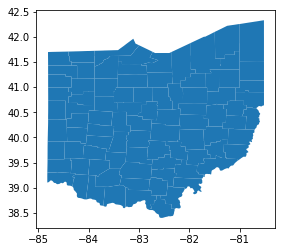

In [45]:
a[a.STATEFP=="39"].plot()

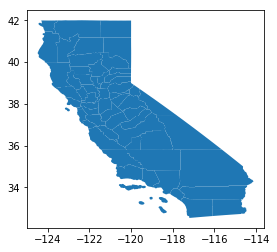

In [46]:
a[a.STATEFP=="06"].plot()

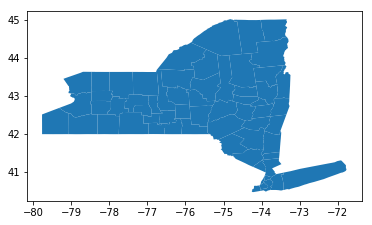

In [47]:
a[a.STATEFP=="36"].plot()